## Основная информация

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

**Описания полей:**

* client_id - идентификатор клиента

* education - уровень образования

* sex - пол заемщика

* age - возраст заемщика

* car - флаг наличия автомобиля

* car_type - флаг автомобиля иномарки

* decline_app_cnt - количество отказанных прошлых заявок

* good_work - флаг наличия “хорошей” работы

* bki_request_cnt - количество запросов в БКИ

* home_address - категоризатор домашнего адреса

* work_address - категоризатор рабочего адреса

* income - доход заемщика

* foreign_passport - наличие загранпаспорта

* sna - связь заемщика с клиентами банка

* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ

* region_rating - рейтинг региона

* app_date - дата подачи заявки

* default - флаг дефолта по кредиту

**Метрика качества**

Результаты оцениваются по площади под кривой ROC AUC

## 1. Импорт библиотек 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

In [3]:
from pandas import Series
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [4]:
# изменим параметры для изображений и графиков
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

%config InlineBackend.figure_format = 'svg' 

# увеличим дефолтный размер графиков
from pylab import rcParams
# rcParams['figure.figsize'] = 8, 5
# from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

pd.set_option('display.max_columns', None)
np.set_printoptions(precision=2)


In [5]:
#Подготовим функции для анализа данных:

#Определение наличия выбросов в отдельном признаке датасета.
def outliers(df_col):
    q1 = df_train[df_col].quantile(0.25)
    q3 = df_train[df_col].quantile(0.75)
    IQR = q3 - q1
    low = q1 - (1.5 * IQR)
    high = q3 + (1.5 * IQR)
    for i in df_train[df_col]:
        if (i <= low) or (i >= high):
            print("В признаке '{}' есть выбросы".format(df_col))
            break
        
    print("Количество выбросов в признаке '{}': {}."
          .format(df_col, ((df_train[df_col] < (q1 - 1.5 * IQR)) | (df_train[df_col] > (q3 + 1.5 * IQR))).sum()))
    print("25-й процентиль: {}, 75-й процентиль: {}, IQR: {}, Границы выбросов: [{}, {}]".format(q1, q3, IQR, low, high))
    
#Функция для анализа численных признаков.    
def numerical_features(item_name, n_bins=100):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        
    # boxplot    
    df_train.boxplot(column=item_name, ax=axes[0])
    axes[0].set_title(item_name, fontsize=22)
    
    # distplot
    sns.distplot(df_train[item_name], bins=n_bins, kde=False, ax=axes[1], vertical=True)
    axes[1].set_title(item_name, fontsize=22)
    plt.xticks(rotation=45)
         
    # descriptive statistics
    print(pd.DataFrame(df_train[item_name].describe()).T, "\n")
    
#Функция для разбиения датасета на тренировочный и валидационный    
def split(df):
    y = df.default.values            
    x = df.drop(columns=['default'])
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
    return X_train, X_test, y_train, y_test
 
    
#Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index = metrics)
def summary_metrics(summary,col,y_valid,y_pred,y_pred_probs):
    values = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred), f1_score(y_valid,y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary  
    
# кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

# Confusion matrix
def conf_mat(y_valid, y_pred):
    P = np.sum(y_valid==1)
    N = np.sum(y_valid==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print(tp, fp) 
    print(fn, tn)  

In [6]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

## 2. Импорт данных

In [7]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
sample_submission = pd.read_csv(PATH_to_file+'/sample_submission.csv')


print('Размерность тренировочного датасета: ', df_train.shape)

print('Размерность тестового датасета: ', df_test.shape)


Размерность тренировочного датасета:  (73799, 19)
Размерность тестового датасета:  (36349, 18)


In [8]:
display(df_train.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [9]:
display(df_train.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [10]:
# Для обработки признаков объединяем трейн и тест в один датасет

df_train['sample'] = 1   
df_test['sample'] = 0    
df_test['default'] = -1  

data = df_test.append(df_train, sort=False).reset_index(drop=True)   # объединяем

## 3. EDA

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [12]:
(data.isna()).sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [13]:
data['region_rating'].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

### Рассмотрим полученные данные  

Суммарно в обоих базах содержится информация о 110148 клиенте (в тренировочной выборке - 73799, в тестовой выборке - 36349) 

Для них есть информация по 20 признакам - 1 временной ряд, 7 бинарных, 6 категориальных и 6 числовых. 

Суммарно в обоих базах содержится 478 пропусков (в тренировочной выборке - 307, в тестовой выборке - 171), все пропуски в переменной Education. 

***client_id*** уникальный числовой признак, который содержит числовой признак клиента. Вероятно, не несет полезной информации для модели - удаляем его.  

In [14]:
data.drop(['client_id'], axis=1, inplace=True)

In [15]:
# создаём списки на основании резюме
# client_id, default, sample не включаем в списки

# временной ряд (1)
time_cols = ['app_date']

# бинарные признаки (7-2)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные признаки (6)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые признаки (6-1)
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

# default признаём целевой переменной 
target = 'default'

Количество выбросов в признаке 'age': 0.
25-й процентиль: 30.0, 75-й процентиль: 48.0, IQR: 18.0, Границы выбросов: [3.0, 75.0]
       count       mean        std   min   25%   50%   75%   max
age  73799.0  39.280641  11.520378  21.0  30.0  37.0  48.0  72.0 

В признаке 'decline_app_cnt' есть выбросы
Количество выбросов в признаке 'decline_app_cnt': 12585.
25-й процентиль: 0.0, 75-й процентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]
                   count      mean       std  min  25%  50%  75%   max
decline_app_cnt  73799.0  0.275749  0.804272  0.0  0.0  0.0  0.0  33.0 

В признаке 'score_bki' есть выбросы
Количество выбросов в признаке 'score_bki': 351.
25-й процентиль: -2.259533835, 75-й процентиль: -1.56983126, IQR: 0.6897025750000001, Границы выбросов: [-3.2940876975, -0.5352773974999998]
             count      mean       std       min       25%       50%  \
score_bki  73799.0 -1.904724  0.498231 -3.624586 -2.259534 -1.920823   

                75%       max  
score_bki -

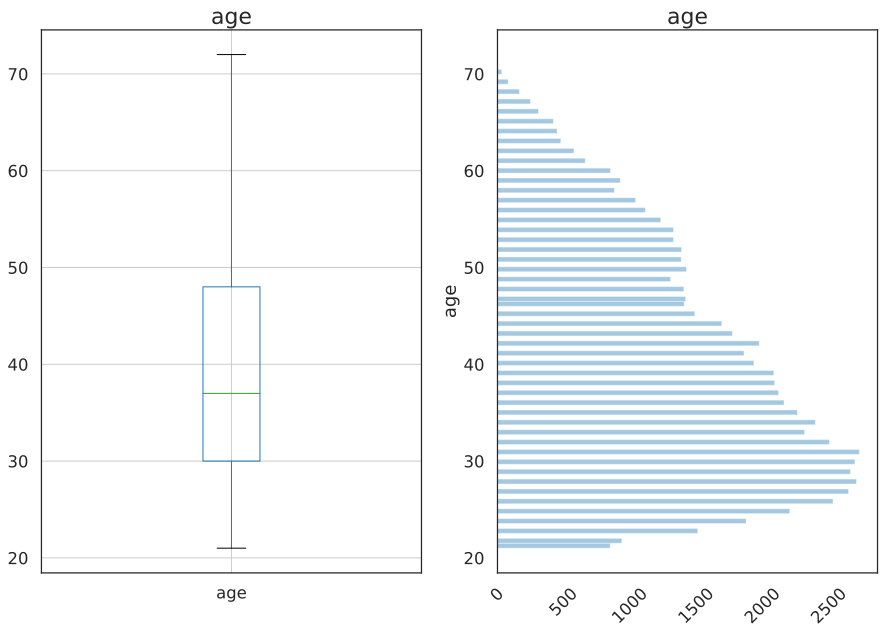

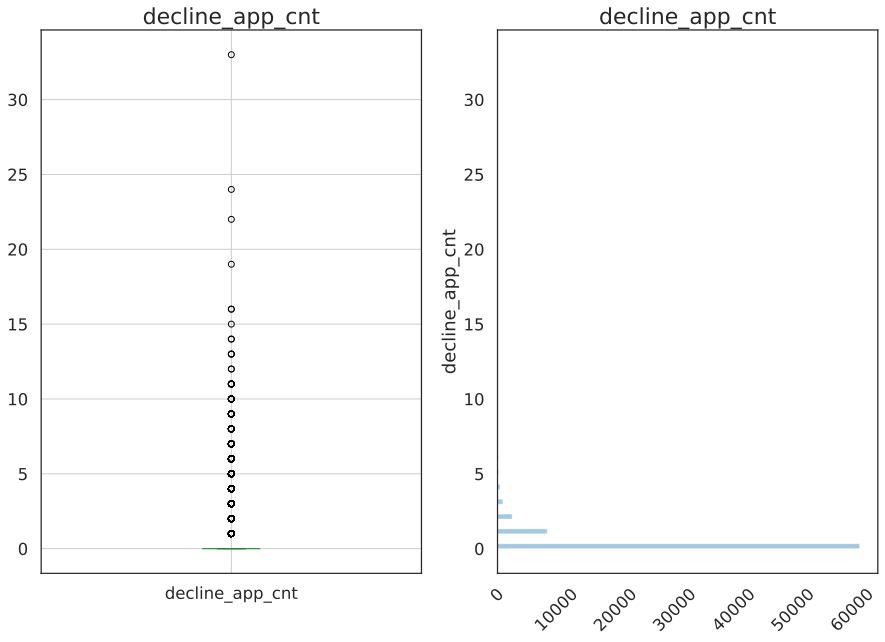

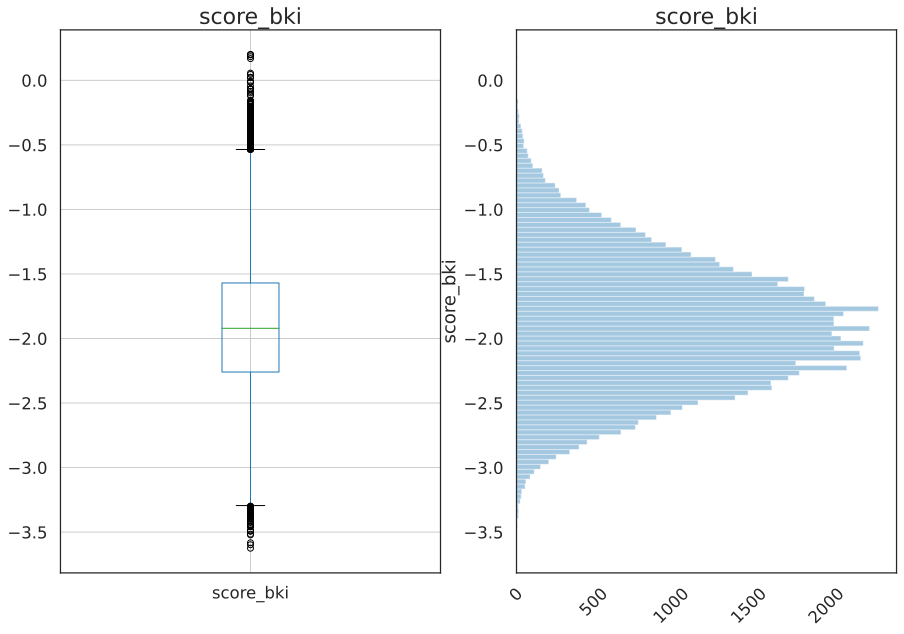

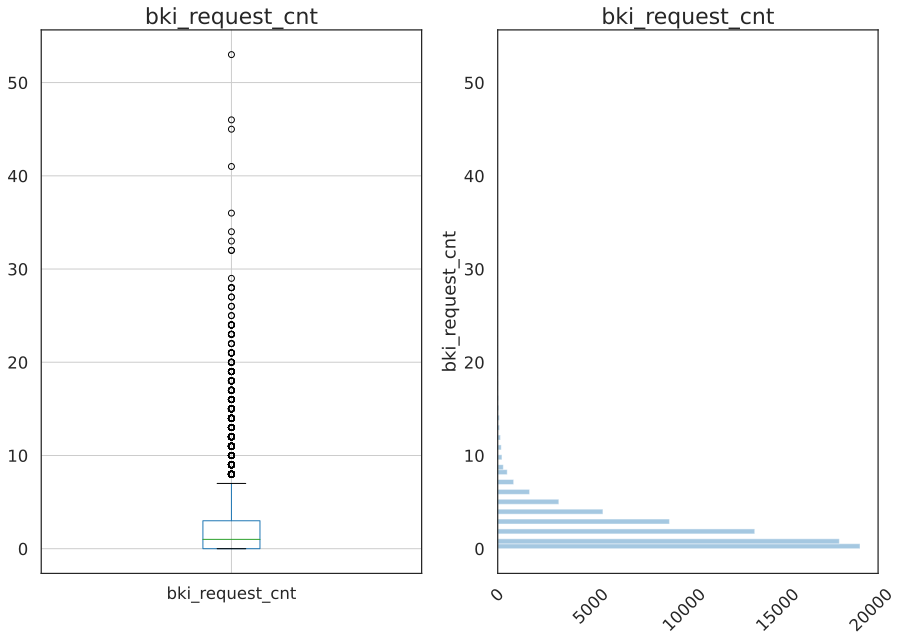

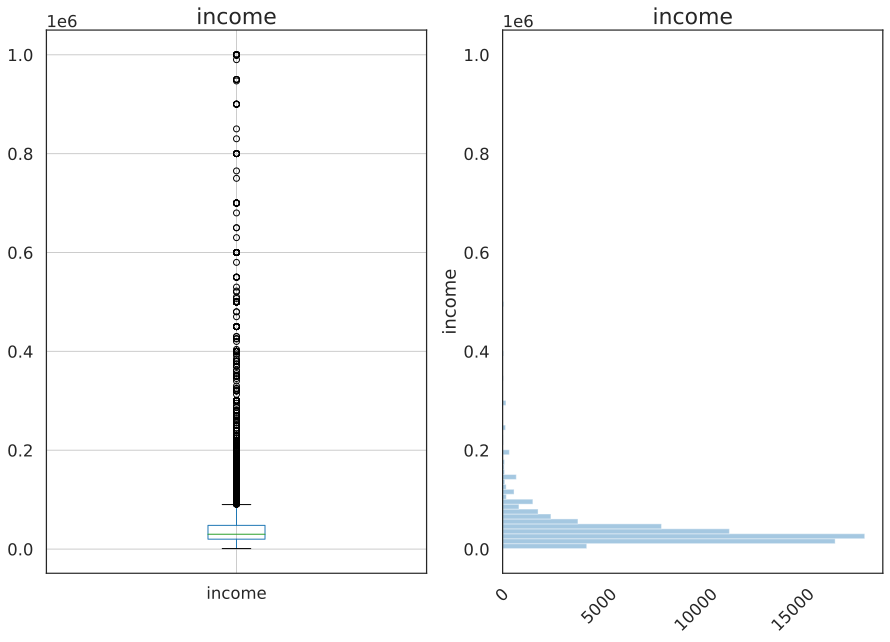

In [16]:
for col in num_cols:
    outliers(col)
    numerical_features(col)

После построения гистограмм стало очевидно, что распределения почти всех числовых переменных имеют тяжёлый правый хвост. 

**age**: Распределение нормальное, выбросов по нет.

**decline_app_cnt**: Распределение нормальное, выбросов достаточно много, произведем логарифмирование.

**score_bki**: Распределение нормальное, выбросов незначительно.

**bki_request_cnt**: Распределение нормальное, выбросов незначительно, произведем логарифмирование

**income**: Распределение нормальное, выбросов достаточно много, произведем логарифмирование.

In [17]:
# логорифмируем выбранные показатели
for i in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    data[i] = np.log(data[i] + 1)
   

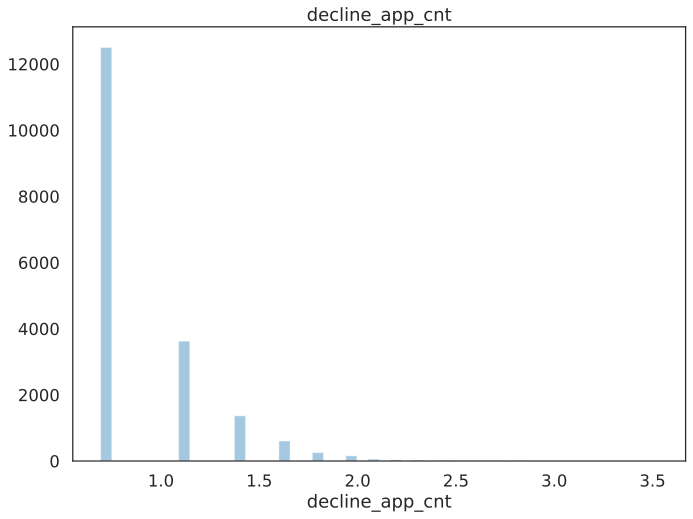

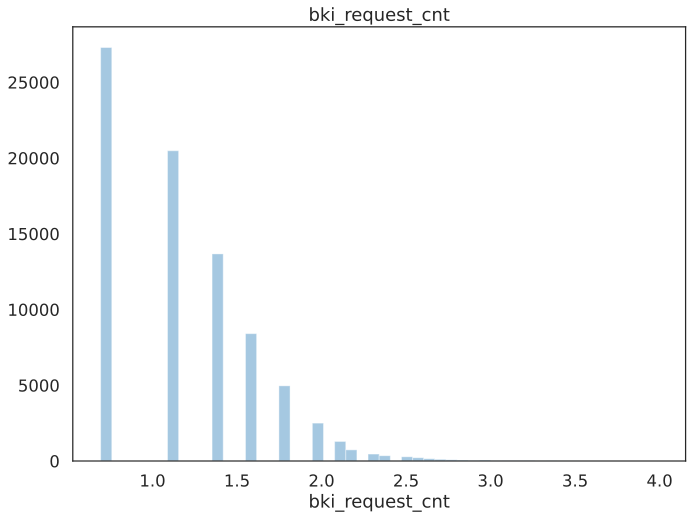

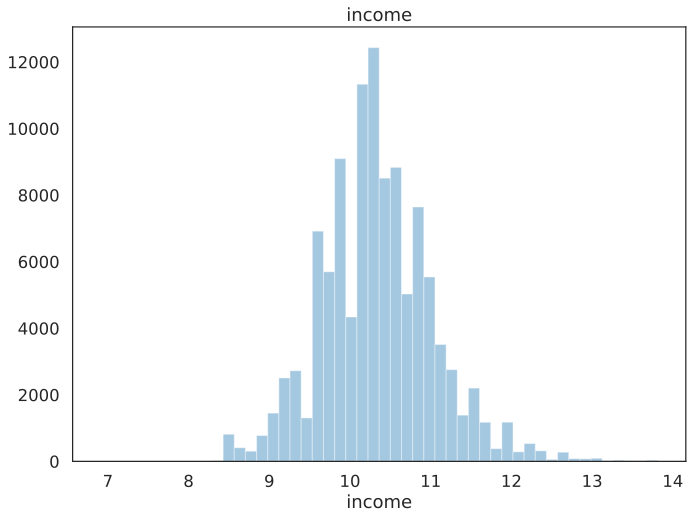

In [18]:
# построим повторно графики для скорректированных показателей
for i in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Признак ***income*** стал менее смещённым. Выбросов стало меньше во всех скорректированных признаках. Однако признаки ***decline_app_cnt*** и ***bki_request_cnt*** требуют дополнительного анализа.

### Преобразование временного ряда.


Преобразуем формат даты.

In [19]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
data.head(3)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,2014-03-22,GRD,M,29,Y,Y,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,N,0,-1
1,2014-01-24,SCH,F,39,N,N,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,N,0,-1
2,2014-03-23,UGR,M,50,Y,Y,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,Y,0,-1


В признаке содержится информация о дате запроса, думаю дата запроса никак не может повлиять на дефолт клиента, удаляем данный признак.

In [20]:
data.drop(['app_date'], axis=1, inplace=True)

### Оценка значимости непрерывных переменных.

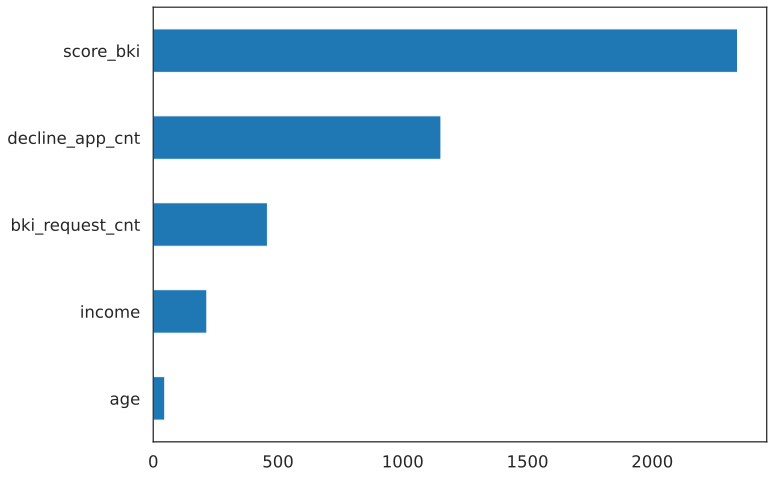

In [21]:
data_temp = data.loc[data['sample'] == 1] 
imp_num = Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Резюме по оценке значимости числовых переменных: 
Скорринговый балл БКИ (**score_bki**) является самым значимым показателем согласно однофакторного дисперсионного анализа, менее значимым является кол-во отказанных ранее заявок (**declain_app_cnt**). Остальные признаки не оказывают существенного влияния на целевой показатель. Признак decline_app_cnt имеет очень большое количество выбросов и ненормальное распределения для модели. 
Нужно будет провести дополнительную работу.

### Категориальные и бинарные признаки:

Education  
Категории в данном признаке имеют следующие значение:
* SCH    (школа)
* GRD    (бакалавр)
* UGR    (кандидат в бакалавры)
* PGR    (магистр)
* ACD    (академик)

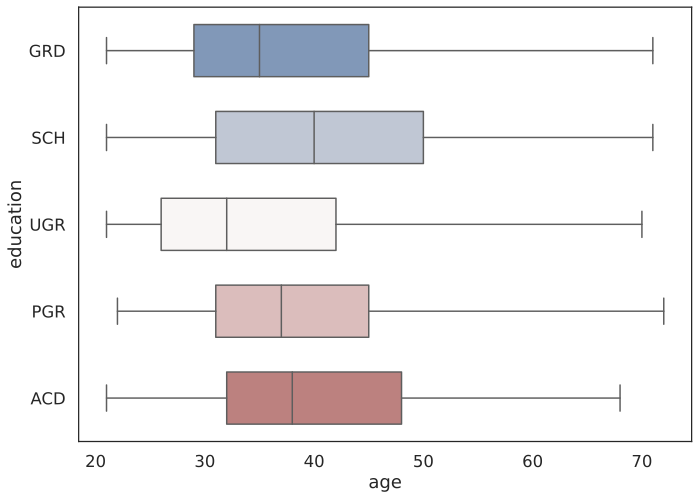

In [22]:
sns.boxplot(x="age", y="education", data=data, whis=[0, 100], width=.6, palette="vlag")

В данном признаке у нас много пропусков - 478, преположим, что это в бланке нет ячейки "незаконченное среднее образование", заменим NaN значения на WOE 

In [23]:
data.education.fillna('WOE', inplace=True)

In [24]:
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
WOE      478
ACD      291
Name: education, dtype: int64

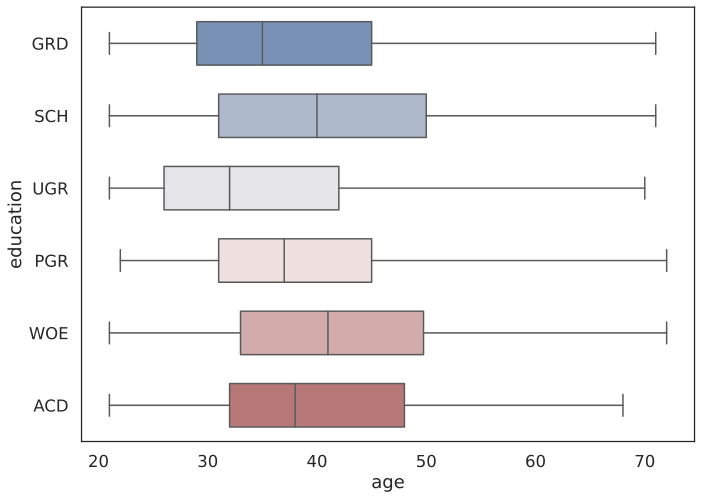

In [25]:
# оценим их распределение визуально
sns.boxplot(x="age", y="education", data=data, whis=[0, 100], width=.6, palette="vlag")

In [26]:
ordinal_enc = OrdinalEncoder(categories=[['WOE', 'SCH', 'GRD', 'UGR', 'PGR', 'ACD'],])
data[['education',]] = ordinal_enc.fit_transform(data[['education',]])

In [27]:
# переводим бинарные признаки в числовой формат

label_encoder = LabelEncoder()

for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [28]:
data.sample(3)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
65839,2.0,0,36,0,0,0.0,0,-1.831759,1.609438,50,1,1,9.798183,2,3,1,1,0
6846,2.0,0,40,1,1,0.0,0,-1.739433,0.693147,70,1,3,10.714440,1,3,0,0,-1
99686,1.0,0,57,0,0,0.0,0,-1.811149,1.609438,60,2,3,8.517393,1,2,0,1,0


### Оценка значимости категориальных и бинарных переменных.

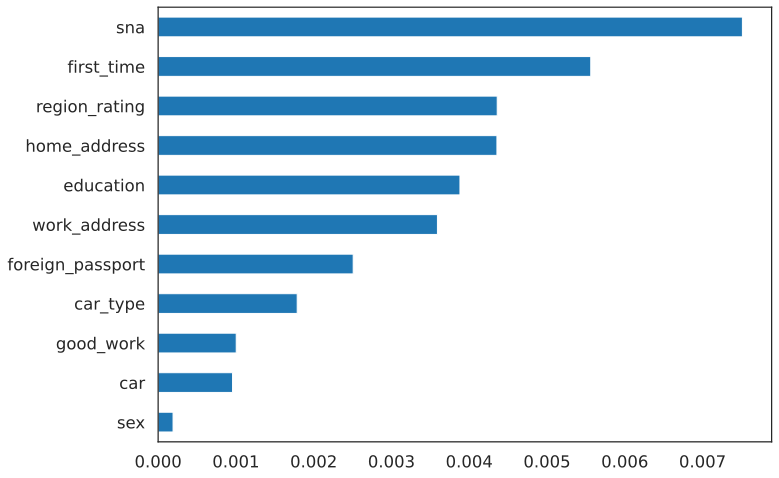

In [29]:
# для бинарных и категориальных признаков (переведенных в числа)
data_temp = data.loc[data['sample'] == 1]
imp_cat = Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#### Резюме по оценке значимости категориальных и бинарных переменных:
Самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (**sna**). Далее, давность наличия информации о заемщике (**first_time**), а затем, практически с одинаковым значением, идет рейтинг региона (**region_rating**) и категоризатор домашнего адреса (**home_address**). Ещё одним достаточно значимым для модели признаком явялется уровень образования клиента (**education**)

## Подготовка данных к машинному обучению.

### Определение дисбаланса классов

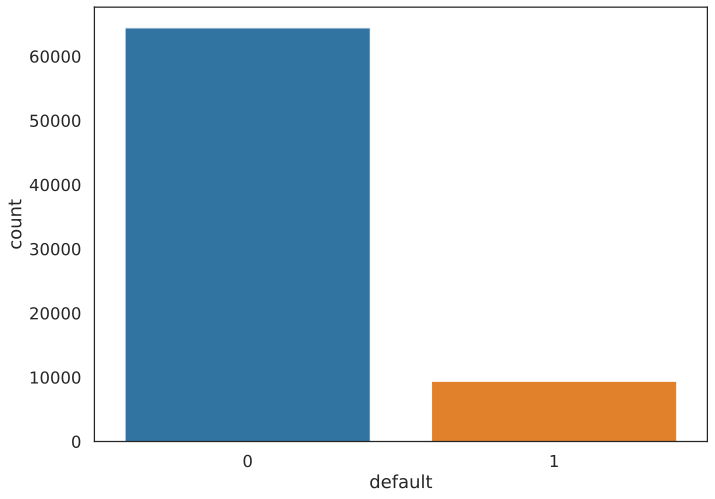

In [30]:
sns.countplot(data_temp['default'])

In [31]:
data_temp['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Дисбаланса классов нет. Согласно теории, когда мы используем вероятностные модели для бинарной классификации, во время обучения модели не сильно зависят от баланса классов, а при тестировании будет использоваться метрика ROC_AUC, обладающая низкой чувствительностью к балансу классов. 

### Применение dummy-кодированием для категориальных переменных

In [32]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

### Стандартизация числовых признаков

In [33]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = data[num_cols].columns)

### Выделение тренировочной и тестовой частей датасета

In [34]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)


In [35]:
X = train_data.drop(['default'], axis=1)
y = train_data.default.values            # наш таргет

## Построение модели

### Разбиение тренировочного датасета на тренировочную и валидационную части


In [36]:
# разделим на тренировочные и валидационные выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [37]:
lr = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)

In [38]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [39]:
probs = lr.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = lr.predict(X_valid)

In [40]:
summary_metrics(summary,'model_1',y_valid,y_pred,y_pred_probs)

,model_1
accuracy,0.875339
precision,0.428571
recall,0.021346
f1_score,0.040667
ROC_AUC,0.741956


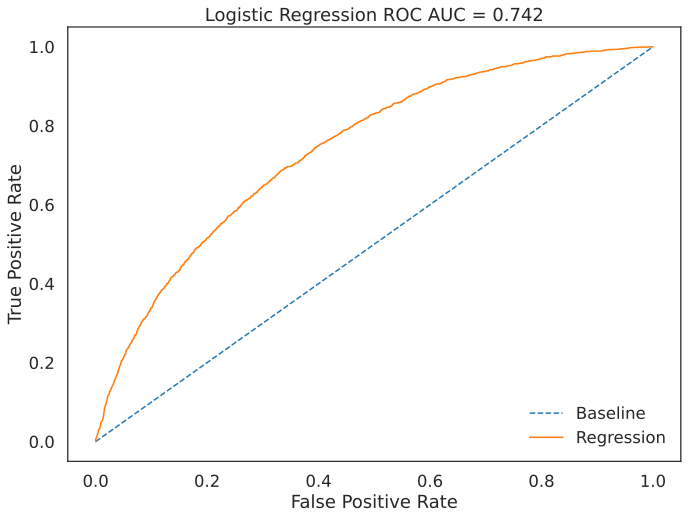

In [41]:
# построим кривую roc
roc_auc_curve(y_valid, y_pred_probs)

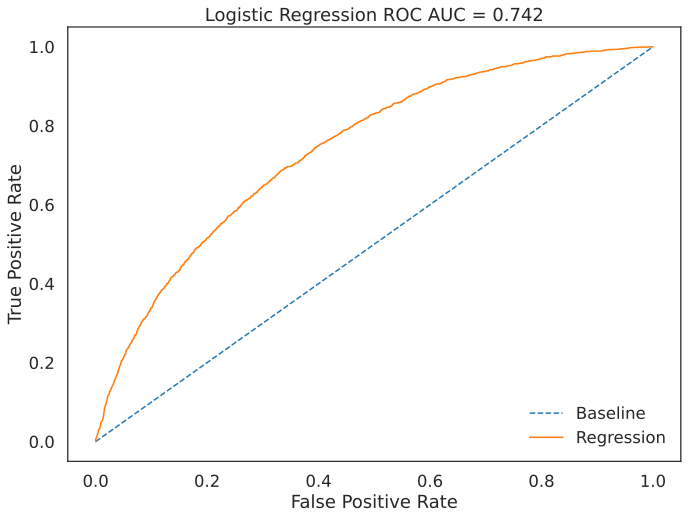

In [42]:
# построим кривую roc
roc_auc_curve(y_valid, y_pred_probs)

In [43]:
# и выведем confusion matrix
conf_mat(y_valid, y_pred)

Positive: 1827, Negative: 12933
39 52
1788 12881


### Выводы по результатам работы первой модели

Несмотря на относительно высокий показатель ROC_AUC, модель показывает абсолютно неудовлетворительную работу. Об этом свидетельствует очень низкий показатель количества правильных предсказаний, т.е. велика вероятность дефолта по выданным кредитам и прямая потеря банком ресурсов. 

### Поиск оптимальных параметров модели

In [44]:
# попробуем подобрать параметры

C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)
   

In [45]:
# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 0.2782559402207124,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 1000,
  multi_class = auto,
  n_jobs = None,
  penalty = l1,
  random_state = 42,
  solver = liblinear,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


### Построение модели после первой оптимизации

In [46]:
# обучаем модель с подобранными параметрами
model_2 = LogisticRegression(C = 0.1,
                                      class_weight = 'balanced',
                                      dual = False,
                                      fit_intercept = True,
                                      intercept_scaling = 1,
                                      l1_ratio = None,
                                      max_iter = 1000,
                                      multi_class = 'auto',
                                      n_jobs = None,
                                      penalty = 'l1',
                                      random_state = 42,
                                      solver = 'liblinear',
                                      tol = 0.001,
                                      verbose = 0,
                                      warm_start = False)


In [47]:
model_2.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.001)

In [48]:
probs = model_2.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model_2.predict(X_valid)

In [49]:
summary_metrics(summary,'model_2',y_valid,y_pred,y_pred_probs)

,model_1,model_2
accuracy,0.875339,0.665312
precision,0.428571,0.223092
recall,0.021346,0.686371
f1_score,0.040667,0.336735
ROC_AUC,0.741956,0.741729


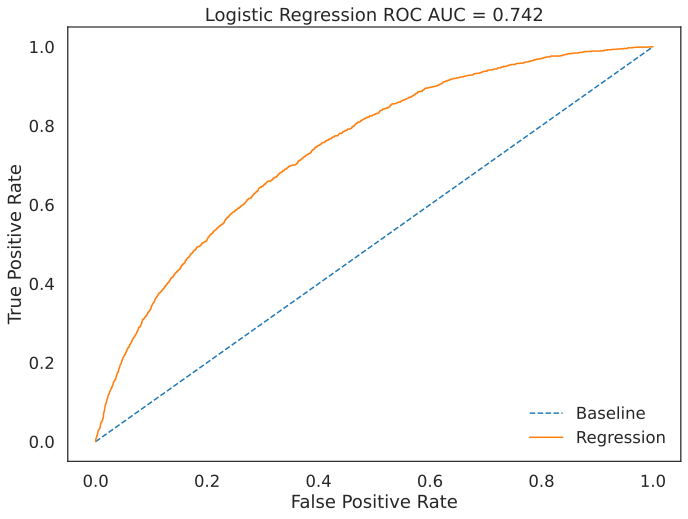

In [50]:
roc_auc_curve(y_valid, y_pred_probs)

In [51]:
conf_mat(y_valid, y_pred)

Positive: 1827, Negative: 12933
1254 4367
573 8566


##  Submission

Восстановим повторно тренировочный и тестовый датафреймы из объединённого датасета.

In [52]:
X_test = test_data.drop(['default'], axis=1)

In [53]:
y_pred_prob = model_2.predict_proba(X_test)[:,1]

In [54]:
submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob

In [55]:
submit.to_csv('submission.csv', index=False)

In [56]:
submit

,client_id,default
0,74835,0.224306
1,17527,0.774649
2,75683,0.328624
3,26883,0.387197
4,28862,0.124366
...,...,...
36344,83775,0.787296
36345,106254,0.143369
36346,81852,0.807734
36347,1971,0.566168
